# [IAPR 2019:][iapr2019] Lab 1 ‒  Image segmentation

**Author:** Jelena Banjac, Darko Lukic  
**Due date:** 04.04.2019

[iapr2019]: https://github.com/LTS5/iapr-2019

In [1]:
import os
import sys
import tarfile
import xml.etree.ElementTree as ET

import numpy as np
import scipy.spatial as ss

import cv2
import skimage.io
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from skimage import exposure
from skimage.measure import regionprops, label

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [2]:
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, f'{data_folder}.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least **region growing** and **contour detection**.

### 1.1 Brain image visualization

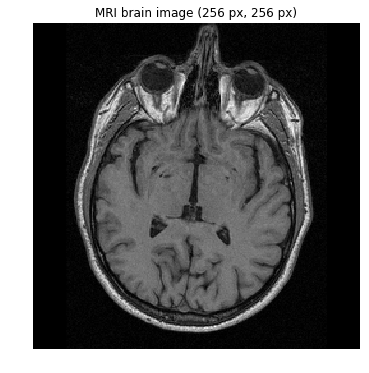

In [3]:
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title(f'MRI brain image ({im_h} px, {im_w} px)')
ax.axis('off')
plt.show()

### 1.2 Region growing
Add your implementation and discussion

In this task we have used region growing technique to measure the brain size. Region growing starts from the given
coordinate and it keeps exploring neighbours. If neighbour fits the constraints it is marked as a part of desired region and it becomes next start of exploration. The algorithm keeps running until no other neighbours fullfil the constraints.

Our implementation is using recursions to explore the neighbours. Although it uses recursion it can be replaced by loops. The implementation is highly inspired to Flood fill algorithm (https://en.wikipedia.org/wiki/Flood_fill).

Size of brain is 14730.0 pixels


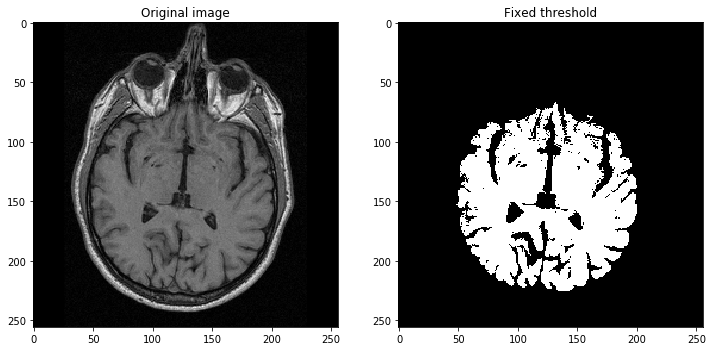

In [4]:
%matplotlib inline

def region_growing_adaptive(img, new_img, x, y, threshold):
    if new_img[x, y] != 0 or x < 0 or y < 0 or x >= img.shape[0] or y >= img.shape[1]:
        return
    else:
        new_img[x, y] = 255
        for step_x, step_y in zip([-1, 1, 0, 0, 1, -1, -1, 1], [0, 0, -1, 1, 1, -1, 1, -1]):
            step_x += x
            step_y += y
            if (abs(int(img[x, y]) - img[step_x, step_y])) < threshold:
                region_growing(img, new_img, step_x, step_y, threshold)
                
            
def region_growing(img, new_img, x, y, target, threshold):
    if new_img[x, y] == 0 and x >= 0 and y >= 0 and x < img.shape[0] and y < img.shape[1]:
        new_img[x, y] = 1
        for step_x, step_y in zip([-1, 1, 0, 0, 1, -1, -1, 1], [0, 0, -1, 1, 1, -1, 1, -1]):
            if (abs(target - img[step_x + x, step_y + y])) < threshold:
                region_growing(img, new_img, step_x + x, step_y + y, target, threshold)
                

resized = cv2.resize(brain_im, dsize=(256, 256))
sys.setrecursionlimit(resized.shape[0] * resized.shape[1])


# region_growing(resized, new_img1, 45, 95, 4)
region_img = np.zeros(resized.shape)
region_growing(resized, region_img, 86, 156, 80, 18)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121)
ax.imshow(resized, cmap='gray')
ax.set_title('Original image')
ax = fig.add_subplot(122)
ax.imshow(region_img, cmap='gray')
ax.set_title('Fixed threshold')

print(f'Size of brain is {np.sum(region_img)} pixels')

### 1.3 Contour detection
Add your implementation and discussion

We used active contours (snakes) to detect a shape of the brain. 

In preprocessing step dilatation is used. We discovered that in this specific case dilatation is more effficient than gauss filter because it doesn't 
blur edges but enchances desired edges. It was important since "snakes" are attracted by edges. Tweaking $ \alpha $ and $ \beta $ (contraction and smoothing coefficients) parameters was much easier then. 

FigureCanvasNbAgg()

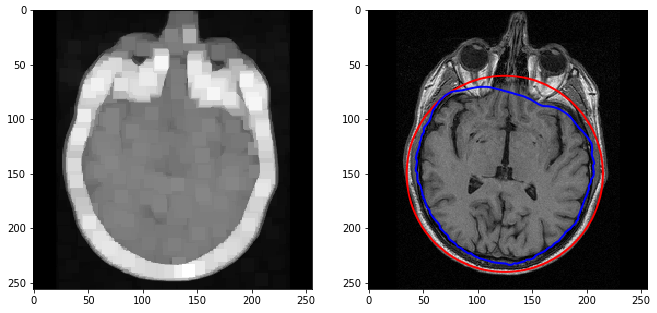

In [5]:
%matplotlib widget


s = np.linspace(0, 2*np.pi, 400)
x = 125 + 90*np.cos(s)
y = 150 + 90*np.sin(s)
init = np.array([x, y]).T


kernel = np.ones((12, 12))
img_pre = cv2.dilate(resized, kernel) 

snake = active_contour(img_pre, init, alpha=0.4, beta=0.1)
ss.ConvexHull(snake)

fig, ax = plt.subplots(1, 2, figsize=(11, 7))
ax[0].imshow(img_pre, cmap='gray')

ax[1].imshow(resized, cmap=plt.cm.gray)
ax[1].plot(init[:, 0], init[:, 1], 'r', lw=2)
ax[1].plot(snake[:, 0], snake[:, 1], 'b', lw=2)

### 1.4 Additional method(s)
Add your implementation and discussion

#### 1.4.1 Closing

We noticed that we cannot filter the brain by colour becuase the skull is the same colour as the brain. However, the skull has many separated regions divided in small pieces. Therefore, we decided to use closing, erode + dilatation. With this approach small regions are deleted and we got a size of the brain.

In addition, we got interested in implementation of morphological approach, therefore we implemented dilatation by ourself.

FigureCanvasNbAgg()

Size of brain is 13911.0 pixels


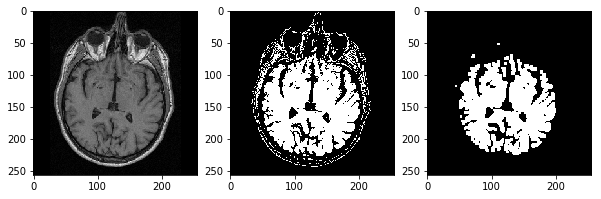

In [6]:
# Dilatation

%matplotlib widget


def dilatation(img, kernel):
    # Doesn't work if kernel size % 2 == 1
    
    M, N = img.shape
    KM, KN = kernel.shape
    KM_H, KN_H = KM // 2, KN // 2
    
    img_out = np.zeros(img.shape)
    
    for i in range(KM_H, M-KM_H):
        for j in range(KN_H, N-KN_H):
            max_pixel = np.max(img[i-KM_H:i+KM_H, j-KN_H: j+KN_H])
            img_out[i-KM_H:i+KM_H, j-KN_H:j+KN_H] = kernel * max_pixel
            
    return img_out


resized = cv2.resize(brain_im, dsize=(256, 256))
filtered = np.matrix((resized > 62) & (resized < 98), dtype=np.uint8)

kernel = np.ones((4, 4))

fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(resized, cmap='gray')
ax[1].imshow(filtered, cmap='gray')
filtered = cv2.erode(filtered, kernel) 
filtered = dilatation(filtered, kernel) 
ax[2].imshow(filtered, cmap='gray')
plt.show()


print(f'Size of brain is {np.sum(filtered)} pixels')

## Part 2: Save the bees !

Varroa mites are recognized as the biggest pest to honey bees worldwide, and are believed to be the single largest contributing factor in the modern-day decline of honey bees due to their ability to transmit diseases, resulting in death or severe deformity of the pupae. 

Detecting and quantifying the presence of Verroa in a beehive is therefore crucial to treat the infection appropriately and as early as possible, and image analysis appears very useful in this problem.

![Varroa Mite](https://lts5www.epfl.ch/wp-content/uploads/2018/07/varroa-2.jpg)



### 2.1 Introduction to Project

You will find hereafter a set of 4 images taken under real conditions. In this task you will be ask to:
1. Count the number of Varroa on each picture
2. Determine the Intersection over Union of the detected patterns w.r.t. the ground truth
3. Estimate the Precision, Recall and F1-score at two different IoU thresholds $T = {0.5 \text{, and } 0.9}$


**Note** 

Try to have the same routine(s) running on the four images, and giving (approximatively) the same results. The routine(s) that you will write for this part will be useful for the final project as well, so pay special attention to it.

#### Vocabulary


* **IoU**: Let $A$ be the ground truth area and $B$ the predicted one. the intersection over union (IoU) is given as:
$$IoU(A,B) = \frac{A \cap B}{A \cup B} = \frac{\text{Area of Overlap}}{\text{Area of Union}}$$
Let $T$ be a scalar in the interval $[0, 1]$, then $B$ will be considered as a true positive (TP) if and only if $IoU(A,B) \ge T$. As a results, we can evaluate the performance of our detection with different values of $T$. The larger $T$ is, the more constraining is our condition.


* **Precision**: The precision is given as:
$$precision = \frac{tp}{tp + fp}$$
where $tp$ is the number of true positives and $fp$ the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.


* **Recall**: The recall is given as:
$$precision = \frac{tp}{tp + fn}$$
where $tp$ is the number of true positives and $fn$ the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.


* **F1-score**: The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:
$$F1 = \frac{2 \cdot precision \cdot recall}{precision + recall}$$


**FAQ**

Q: What to do if I have multiple ground truth $A_i$ and candidates $B_j$ and want to find the best set $(i,j)$ such that $(i, j) = \arg\max_{i,j} IoU(A_i, B_j)$ ? 

A: Here, we recommend to use a brute force approach. It corresponds to compute $IoU(A, B)$ for every possible pairs (i,j) and keep the pair with the highest $IoU$. Note that a candidate $B_j$ can **only** be matched to **one** ground truth area $A_i$.

Here, we visualize the 4 images for our patern detection

In [7]:
# Load images
im_names = ['varroa-01', 'varroa-02', 'varroa-03', 'varroa-04']
filenames = [os.path.join(data_path, name) + '.jpg' for name in im_names]
ic = skimage.io.imread_collection(filenames)
print('Number of images: ', len(ic))

Number of images:  4


FigureCanvasNbAgg()

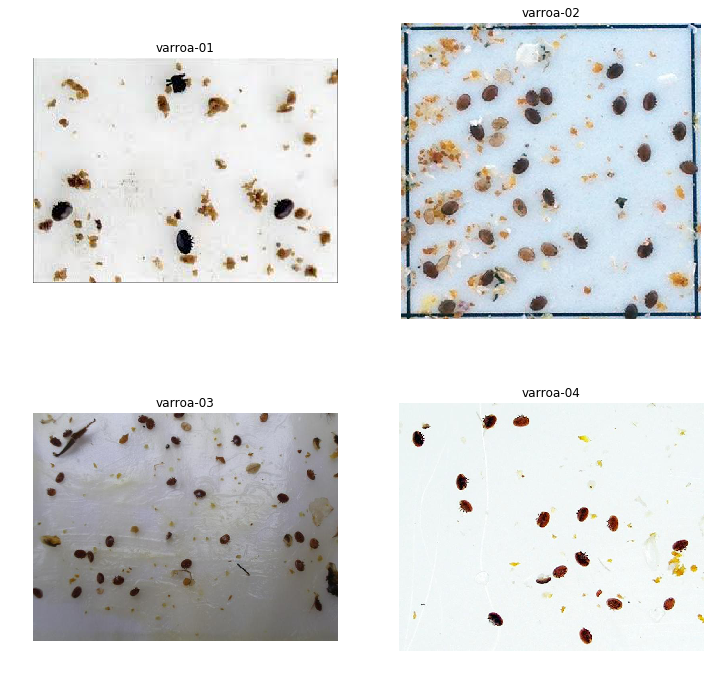

In [8]:
# Plot images
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), ic, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

We can as well add the groud truth label that are stored in the corresponding XML files. Each xml file stores the position of the varroa on the image as :

```xml
<annotation>
	<object>
		<name>Varroa</name>
		<difficult>0</difficult>
		<bndbox>
			<xmin>14</xmin>
			<ymin>117</ymin>
			<xmax>33</xmax>
			<ymax>137</ymax>
		</bndbox>
	</object>
	<object>
		...
	</object>
	...
</annotation>
```
The block `object` defines the attributes of the varroa. `name` is the definition of the object class (always varroa). `bndbox` is the definition of the bounding box. To simplify your task, we implemented a function named `parse_file` that returns an array with the bounding box of the varroa expressed as `(x, y, width, heigth)` which corresponds to `(xmin, ymin, xmax-xmin, ymax-ymin)`

In [9]:
def parse_file(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text))-int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymax').text))-int(float(bbox.find('ymin').text))]
        objects.append(obj_struct)

    return objects

In [10]:
annotations_xmls = [parse_file(os.path.join(data_path, name) + '.xml') for name in im_names]

FigureCanvasNbAgg()

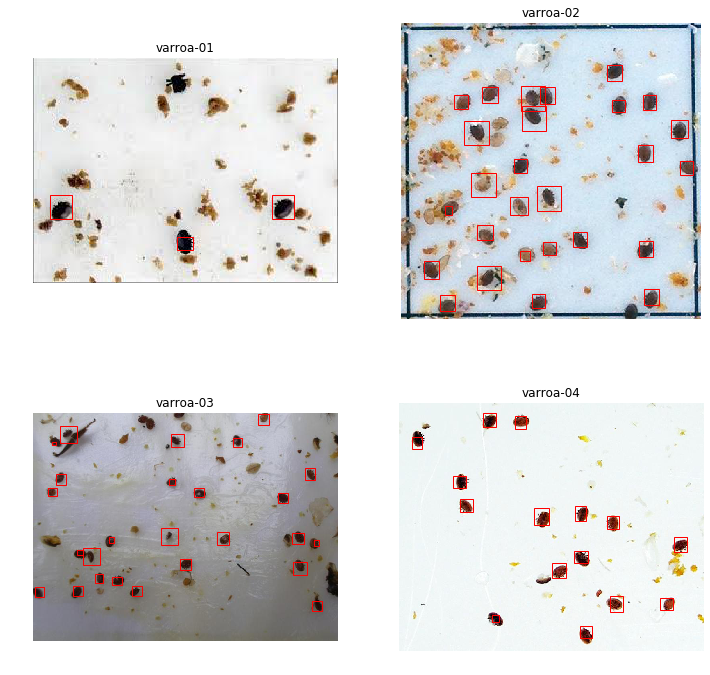

In [11]:
# Plot images
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im, nm, annotations in zip(axes.ravel(), ic, im_names, annotations_xmls):
    # Iterate over annotations
    for anno in annotations:
        rect = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
                linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Count the number of Varroa on each picture

Add your implementation and discussion

Hint: `skimage.measure.label` might be useful to label the thresholded image

Found 3 of 3 bugs
Found 33 of 27 bugs
Found 36 of 26 bugs
Found 15 of 15 bugs


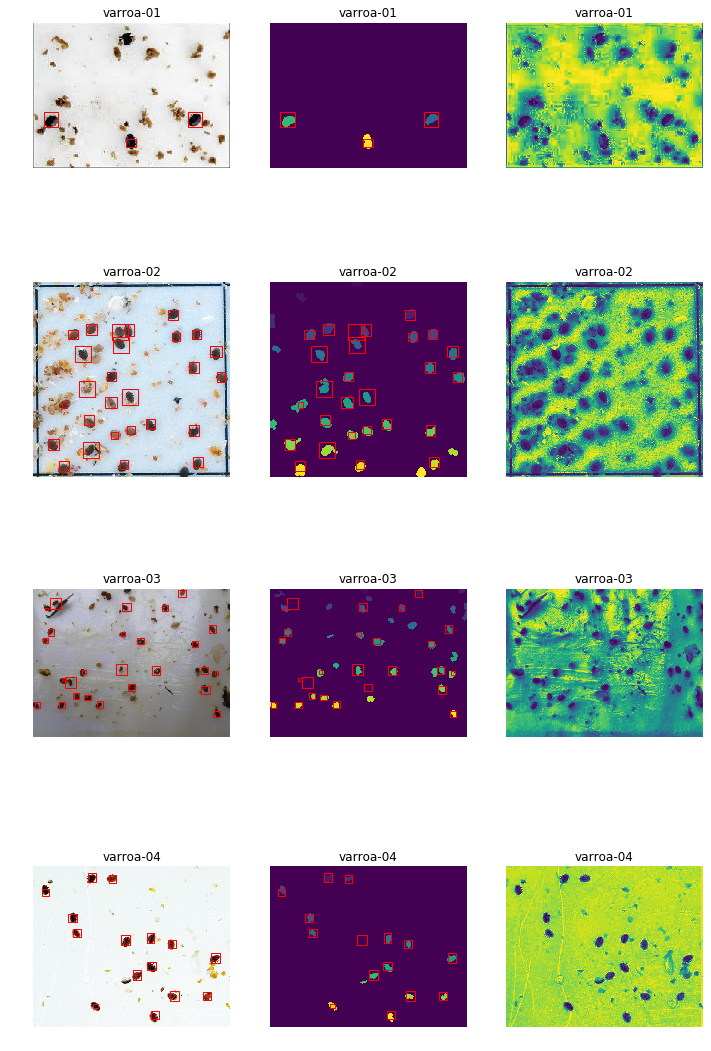

In [12]:
# %matplotlib widget
%matplotlib inline

def my_unit_circle(r):
    res = np.zeros((r, r))
    for i in range(r):
        for j in range(r):
            if (i - r/2 )**2 + (j - r/2)**2 <= r:
                res[i, j] = 1
    return res


def bugy_detection(gray, lower_contour_area, upper_contour_area, lower_dark, upper_dark, lower_shine, upper_shine):  # 180, 0, 50, 50, 110
    mask_dark = cv2.inRange(gray, lower_dark, upper_dark)
    mask_shine = cv2.inRange(gray, lower_shine, upper_shine)
    img_bin = mask_dark|mask_shine
    

    kernel = my_unit_circle(10)

    img_bin = cv2.erode(img_bin, np.uint8(kernel))
    img_bin = cv2.dilate(img_bin, np.uint8(kernel))
    
    contours, h = cv2.findContours(img_bin,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    blank_image = np.zeros((img_bin.shape), np.uint8)
    
    conture_counter = 0
    for cnt in contours:
        if upper_contour_area > cv2.contourArea(cnt) > lower_contour_area:
            cv2.drawContours(blank_image,[cnt],0,(255,255,0),-1)  # -1 means that the contours is filled
            conture_counter += 1
    
    img_lbl = label(blank_image)
    
    return img_lbl, conture_counter

                    
# Plot images
fig, ax = plt.subplots(4, 3, figsize=(12, 20))
     
i = 0
img_lbls = []
for im, nm, annotations in zip(ic, im_names, annotations_xmls):
    # Iterate over annotations
    for anno in annotations:
        rect = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3], linewidth=1,edgecolor='r',facecolor='none')
        ax[i, 0].add_patch(rect)
    
    ax[i, 0].imshow(im)
    ax[i, 0].axis('off')
    ax[i, 0].set_title(nm)
    
    
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    imexp = exposure.equalize_adapthist(gray, clip_limit=0.03)
    ax[i, 2].imshow(imexp)
    ax[i, 2].axis('off')
    ax[i, 2].set_title(nm)
    
    
    for anno in annotations:
        rect = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3], linewidth=1,edgecolor='r',facecolor='none')
        ax[i, 1].add_patch(rect)
        
    img_lbl, bugs_est = bugy_detection(imexp, 127, 650, 0, 0.26, 50, 110)
    img_lbls.append(img_lbl)
    
    ax[i, 1].imshow(img_lbl)
    ax[i, 1].axis('off')
    ax[i, 1].set_title(nm)
    
    print(f'Found {bugs_est} of {len(annotations)} bugs')
    i += 1

plt.show()

### 2.3 IoU of the detected pattern w.r.t. the ground truth

Add your implementation and discussion

Hint: `skimage.measure.regionprops` implements a large variety of descriptors

First, we plot 4 images with the results of our image segmentation. With the **red color** we denote the ground truth, and with the **blue color** we denote the Varroas we detected with our image segmentation.

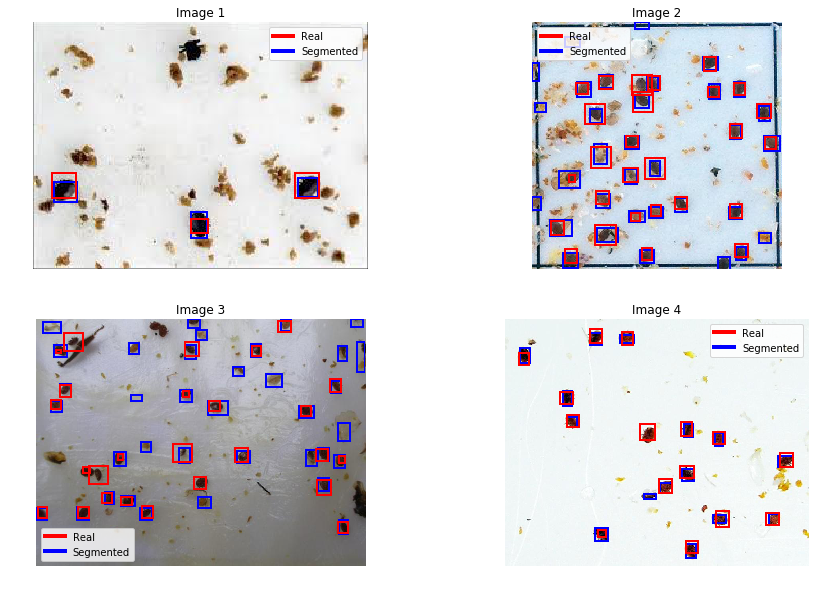

In [13]:
%matplotlib inline

# Colors that will be used in the legend
custom_legend = [Line2D([0], [0], color="r", lw=4, label="Real"),
                Line2D([0], [0], color="b", lw=4, label="Segmented")]
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Iterate through each of the 4 images, and label Real and Segmented Varroas
for iteration, (ax, im, img_lbl, annotations) in enumerate(zip(axes.ravel(), ic, img_lbls, annotations_xmls)):
    props = regionprops(img_lbl)
    
    # Show image with our prediction
    for p in props:
        rect_segm = patches.Rectangle(
            (p['bbox'][1], p['bbox'][2]), 
            p['bbox'][3] - p['bbox'][1], 
            p['bbox'][0] - p['bbox'][2], 
            linewidth=2, edgecolor='b', facecolor='none', label="Predicted")
        ax.add_patch(rect_segm)
    for a in annotations:
        rect_real = patches.Rectangle(
            (a['bbox'][0], a['bbox'][1]), 
            a['bbox'][2], a['bbox'][3], 
            linewidth=2, edgecolor='r',facecolor='none', label="Real")
        ax.add_patch(rect_real)
    ax.imshow(im)
    ax.axis('off')
    ax.legend(custom_legend, ['Real', 'Segmented'])
    ax.set_title(f"Image {iteration+1}")
    

In [14]:
def area(r):
    """ Calculate area size of the rectangle
    
    Parameters
    ----------
    r: patches.Rectangle
        Rectangle which area will be calculated
        
    Returns
    -------
    : float
        Rectangle area size [px], otherwise None
    """
    r_xmax = max(r.get_x(), r.get_x() + r.get_width())
    r_xmin = min(r.get_x(), r.get_x() + r.get_width())
    r_ymax = max(r.get_y(), r.get_y() + r.get_height())
    r_ymin = min(r.get_y(), r.get_y() + r.get_height()) 
    
    dx = r_xmax - r_xmin
    dy = r_ymax - r_ymin
    
    if dx>=0 and dy>=0:
        return dx*dy

def area_intersection(r1, r2):  # returns None if rectangles don't intersect
    """ Size of an intersection area of two rectangles
    
    Parameters
    ----------
    r1: patches.Rectangle
        First rectangle
    r2: patches.Rectangle
        Second rectangle
        
    Returns
    -------
    : float
        Rectangle area size [px], otherwise None
    """
    a_xmax = max(r1.get_x(), r1.get_x() + r1.get_width())
    b_xmax = max(r2.get_x(), r2.get_x() + r2.get_width())
    a_xmin = min(r1.get_x(), r1.get_x() + r1.get_width())
    b_xmin = min(r2.get_x(), r2.get_x() + r2.get_width())
    a_ymax = max(r1.get_y(), r1.get_y() + r1.get_height())
    b_ymax = max(r2.get_y(), r2.get_y() + r2.get_height())
    a_ymin = min(r1.get_y(), r1.get_y() + r1.get_height())
    b_ymin = min(r2.get_y(), r2.get_y() + r2.get_height()) 
    
    dx = min(a_xmax, b_xmax) - max(a_xmin, b_xmin)
    dy = min(a_ymax, b_ymax) - max(a_ymin, b_ymin)
    
    if dx>=0 and dy>=0:
        return dx*dy
    
def area_union(r1, r2):
    """ Size of an union area of two rectangles
    
    Parameters
    ----------
    r1: patches.Rectangle
        First rectangle
    r2: patches.Rectangle
        Second rectangle
        
    Returns
    -------
    : float
        Rectangle area size [px], otherwise None 
    """
    return area(r1) + area(r2) - area_intersection(r1, r2)

In [15]:
def get_performance_scores(im, annotations, props, treshold, debug=False):
    """ Calculates performance scores
    
    This method calculates performance scores: Precision, Recall, F1-scores
    
    Parameters
    ----------
    im: numpy.ndarray
        Default image with varroas on it (not labeled, nor processed anyhow)
    annotations: List of dictionaries
        This is list of annotations read from XML file provided for the exercise
    props: propertieslist of RegionProperties (skimage.measure.regionprops)
        Properties of our labeled image
    treshold: float
        Treshold for IoU in range [0, 1]
    debug: bool
        By default is False, but can be True in order to plot every iteration where intersection of
        true value and predicted one is found.
    
    Returns
    -------
    precision: float, None
        Precision value is calculated with tp / (tp+fp)
    recall: float, None
        Recall value is calculated with tp / (tp+fn)
    f1_score: float, None
        F1-score is calculated with 2*precision*recall / (precision + recall)
    
    Attributes
    ----------
    tp: int
        True Positives
    fp: int
        False Positives
    fn: int
        False Negative
    i_plot: int
        Counts axes for degugging plot
    """
    tp = 0
    fp = 0
    fn = 0
    
    if debug:
        rows = 1 if len(props) < 5 else len(props)//5
        cols = 5 if len(props) >= 5 else len(props)
        fig, ax = plt.subplots(rows, cols, figsize=(15, 15))
        plt.subplots_adjust(wspace=1, hspace=1)
        
    i_plot = 0
    for i, a in enumerate(annotations):
        rect_real = patches.Rectangle((a['bbox'][0], a['bbox'][1]), a['bbox'][2], a['bbox'][3])

        for j, p in enumerate(props):
            rect_segm = patches.Rectangle((p['bbox'][1], p['bbox'][2]), p['bbox'][3] - p['bbox'][1], p['bbox'][0] - p['bbox'][2])   
            
            intersection = area_intersection(rect_real, rect_segm)
            
            if intersection:
                union = area_union(rect_real, rect_segm)
                IoU = intersection/union
                
                if debug:
                    print(f"Image : \n\tIntersection = {intersection}\n\tUnion = {union}\n\tIoU = {IoU:.2f}")
                
                    _ax_num = (i_plot//5, i_plot%5 if i_plot >= 5 else i_plot)
                    _ax_num = _ax_num[1] if rows == 1 else _ax_num
                
                    ax[_ax_num].imshow(im)
                    ax[_ax_num].add_patch(patches.Rectangle((a['bbox'][0], a['bbox'][1]), a['bbox'][2], a['bbox'][3], 
                        linewidth=2, edgecolor='r', facecolor='none'))
                    ax[_ax_num].add_patch(patches.Rectangle((p['bbox'][1], p['bbox'][2]), p['bbox'][3] - p['bbox'][1], p['bbox'][0] - p['bbox'][2], 
                        linewidth=2, edgecolor='b', facecolor='none'))
                    ax[_ax_num].set_title(f"Intersection: {intersection} px")
                
                    i_plot += 1
            
                if intersection:
                    if IoU >= treshold:
                        tp += 1
                    else:
                        fn += 1
    
    fp = len(props) - (tp + fn)
    
    print(f"TP FN FP = {tp} {fn} {fp}")
    
    if tp+fp > 0:
        precision = tp / (tp+fp)
        print(f"Precision = {precision:.2f}")
    else:
        precision = None
        print("Precision could not be calculated since number TP + FP is zero!")
    
    if tp+fn > 0:
        recall = tp / (tp+fn)
        print(f"Recall = {recall:.2f}")
    else:
        recall = None
        print("Recall could not be calculated since number TP + FN is zero!")
    
    if precision and recall and precision+recall > 0:
        f1_score = 2*precision*recall / (precision + recall)
        print(f"F1-score = {f1_score:.2f}")
    else:
        f1_score = None
        print("F1-score could not be calculated since number TP is zero!")
    
    return precision, recall, f1_score

Now, we just plot the performance evaluation with debuging turned on for the first Varroa image. This can be later a nice feature if used for the developning the project in the end of the course.

Image : 
	Intersection = 221
	Union = 447
	IoU = 0.49
Image : 
	Intersection = 240
	Union = 380
	IoU = 0.63
Image : 
	Intersection = 132
	Union = 251
	IoU = 0.53
TP FN FP = 3 0 0
Precision = 1.00
Recall = 1.00
F1-score = 1.00


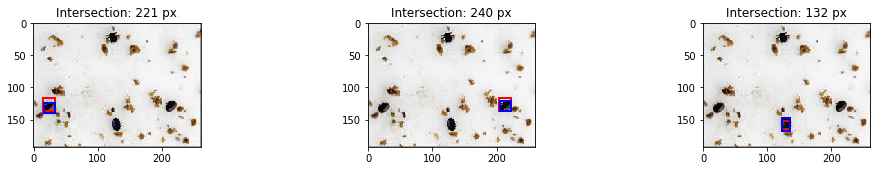

In [16]:
annotations = annotations_xmls[0]
img_lbl = img_lbls[0]
im = ic[0]
props = regionprops(img_lbl)

precision, recall, f1_score = get_performance_scores(im, annotations, props, treshold=0.4, debug=True)

Plot performance evaluation for every of the 4 images we have, with the **TRESHOLD = 0.4**

In [17]:
TRESHOLD = 0.4

for iteration , (im, img_lbl, annotations) in enumerate(zip(ic, img_lbls, annotations_xmls)):
    print(f"\n--- Image: {iteration+1} ---")
    props = regionprops(img_lbl)
    get_performance_scores(im, annotations, props, treshold=TRESHOLD, debug=False)


--- Image: 1 ---
TP FN FP = 3 0 0
Precision = 1.00
Recall = 1.00
F1-score = 1.00

--- Image: 2 ---
TP FN FP = 24 4 5
Precision = 0.83
Recall = 0.86
F1-score = 0.84

--- Image: 3 ---
TP FN FP = 17 7 12
Precision = 0.59
Recall = 0.71
F1-score = 0.64

--- Image: 4 ---
TP FN FP = 12 2 1
Precision = 0.92
Recall = 0.86
F1-score = 0.89


From the results above, using our algorithm, we can see the performance evaluation. The best F1-score can be seen with the first image where the segmentation algorithm sucessfully finds all 3 Varroas. After the image 1, the image 4 is showing very high performance score.

---

### 2.4 Precision, Recall and F1-score at two different IoU thresholds

Add your implementation and discussion

### Treshold T = 0.5

In [18]:
TRESHOLD = 0.5

for iteration , (im, img_lbl, annotations) in enumerate(zip(ic, img_lbls, annotations_xmls)):
    print(f"\n--- Image: {iteration+1} ---")
    props = regionprops(img_lbl)
    get_performance_scores(im, annotations, props, treshold=TRESHOLD, debug=False)


--- Image: 1 ---
TP FN FP = 2 1 0
Precision = 1.00
Recall = 0.67
F1-score = 0.80

--- Image: 2 ---
TP FN FP = 18 10 5
Precision = 0.78
Recall = 0.64
F1-score = 0.71

--- Image: 3 ---
TP FN FP = 16 8 12
Precision = 0.57
Recall = 0.67
F1-score = 0.62

--- Image: 4 ---
TP FN FP = 11 3 1
Precision = 0.92
Recall = 0.79
F1-score = 0.85


We can see that performace results decreased a bit in comparison to TRESHOLD=0.4 ran in the previous section. However, performance results stay preattu high, with the average ~ 75%.

### Treshold T = 0.9

In [19]:
TRESHOLD = 0.9

for iteration , (im, img_lbl, annotations) in enumerate(zip(ic, img_lbls, annotations_xmls)):
    print(f"\n--- Image: {iteration+1} ---")
    props = regionprops(img_lbl)
    get_performance_scores(im, annotations, props, treshold=TRESHOLD, debug=False)


--- Image: 1 ---
TP FN FP = 0 3 0
Precision could not be calculated since number TP + FP is zero!
Recall = 0.00
F1-score could not be calculated since number TP is zero!

--- Image: 2 ---
TP FN FP = 0 28 5
Precision = 0.00
Recall = 0.00
F1-score could not be calculated since number TP is zero!

--- Image: 3 ---
TP FN FP = 0 24 12
Precision = 0.00
Recall = 0.00
F1-score could not be calculated since number TP is zero!

--- Image: 4 ---
TP FN FP = 0 14 1
Precision = 0.00
Recall = 0.00
F1-score could not be calculated since number TP is zero!


In the case with TRESHOLD=0.9, the results are very bad. Our algorithm wasn't able to detect even 1 Positive True Varroa...